In [6]:
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from torch.utils.data import Dataset,DataLoader,TensorDataset
from pytorch_forecasting import TimeSeriesDataSet
from pytorch_forecasting.models import BaseModel
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting import Baseline
import matplotlib.pyplot as plt
from pytorch_lightning import Trainer
from typing import Dict
import torch.nn as nn
import pandas as pd
import numpy as np
import torch
import os
#os.chdir("..")

In [7]:
data = pd.read_csv("data/All_music.csv")
data.sort_values(by=["timestamp"],inplace=True) # for my sanity
data["timestamp"] = pd.to_datetime(data["timestamp"]) # needed to create time_index

#group by month
# data["time_idx"] = data["timestamp"].dt.year * 12 + data["timestamp"].dt.month
# data["time_idx"] -= data["time_idx"].min()

data["month"] = data["timestamp"].dt.month.astype(str).astype("category")
data["log_views"] = np.log(data["views"] + 1e-8)


data["time_idx"] = data.index.astype(int)
#data["timestamp"] = data["timestamp"].astype(str).astype('category')
# (data.groupby("project")["time_idx"].diff() == 1).value_counts()


# # add time index
# data["time_idx"] = data["date"].dt.year * 12 + data["date"].dt.month
# data["time_idx"] -= data["time_idx"].min()
data.drop(["project","granularity","access","agent"],inplace=True,axis=1)
data["article"] = data["article"].astype(str).astype("category")

# Delete wrong data
data = data[data["article"] != "Paper_Doll"]
data = data[data["article"] != "Y.M.C.A"]
data = data[data["article"] != "Bei_Mir_Bist_Du_Schön"]

#new Features
data["dayofweek"] = data["timestamp"].dt.dayofweek.astype(str).astype("category")
data["log_views"] = np.log(data["views"] + 1e-8)
data["month"] = data["timestamp"].dt.month.astype(str).astype("category")
data["year"] = data["timestamp"].dt.year.astype(str).astype("category")
data["avg_by_song"] = data.groupby(["month","year","article"],observed=True)["views"].transform("mean")


data = data[data['article'].map(data['article'].value_counts()) == 2377]
data.drop("Unnamed: 0",inplace=True,axis=1)
data.sort_values(by=["article","timestamp"],inplace=True)
#data["time_idx"] = data["timestamp"].dt.year * 12 + data["timestamp"].dt.month + 365 * data["timestamp"].dt.day
data["time_idx"] = [i for i in range(2377)] * len(data["article"].unique())
data

,article,timestamp,views,month,log_views,time_idx,dayofweek,year,avg_by_song
0,(Everything_I_Do)_I_Do_It_for_You,2015-07-01,639,7,6.459904,0,2,2015,682.548387
1,(Everything_I_Do)_I_Do_It_for_You,2015-07-02,647,7,6.472346,1,3,2015,682.548387
2,(Everything_I_Do)_I_Do_It_for_You,2015-07-03,549,7,6.308098,2,4,2015,682.548387
3,(Everything_I_Do)_I_Do_It_for_You,2015-07-04,638,7,6.458338,3,5,2015,682.548387
4,(Everything_I_Do)_I_Do_It_for_You,2015-07-05,774,7,6.651572,4,6,2015,682.548387
...,...,...,...,...,...,...,...,...,...
150686,You're_the_One_That_I_Want,2021-12-28,217,12,5.379897,2372,1,2021,191.064516
150687,You're_the_One_That_I_Want,2021-12-29,181,12,5.198497,2373,2,2021,191.064516
150688,You're_the_One_That_I_Want,2021-12-30,175,12,5.164786,2374,3,2021,191.064516
150689,You're_the_One_That_I_Want,2021-12-31,279,12,5.631212,2375,4,2021,191.064516


In [8]:
from torch.nn.utils import rnn

from pytorch_forecasting.models.base_model import AutoRegressiveBaseModel
from pytorch_forecasting.models.nn import LSTM


class LSTMModel(AutoRegressiveBaseModel):
    def __init__(
        self,
        target: str,
        target_lags: Dict[str, Dict[str, int]],
        n_layers: int,
        hidden_size: int,
        dropout: float = 0.1,
        **kwargs,
    ):
        # arguments target and target_lags are required for autoregressive models
        # even though target_lags cannot be used without covariates
        # saves arguments in signature to `.hparams` attribute, mandatory call - do not skip this
        self.save_hyperparameters()
        # pass additional arguments to BaseModel.__init__, mandatory call - do not skip this
        super().__init__(**kwargs)

        # use version of LSTM that can handle zero-length sequences
        self.lstm = LSTM(
            hidden_size=self.hparams.hidden_size,
            input_size=7,
            num_layers=self.hparams.n_layers,
            dropout=self.hparams.dropout,
            batch_first=True,
        )
        self.output_layer = nn.Linear(self.hparams.hidden_size, 1)

    def encode(self, x: Dict[str, torch.Tensor]):
        # we need at least one encoding step as because the target needs to be lagged by one time step
        # because we use the custom LSTM, we do not have to require encoder lengths of > 1
        # but can handle lengths of >= 1
        assert x["encoder_lengths"].min() >= 1
        input_vector = x["encoder_cont"].clone()
        # lag target by one
        input_vector[..., self.target_positions] = torch.roll(
            input_vector[..., self.target_positions], shifts=1, dims=1
        )
        input_vector = input_vector[:, 1:]  # first time step cannot be used because of lagging

        # determine effective encoder_length length
        effective_encoder_lengths = x["encoder_lengths"] - 1
        # run through LSTM network
        _, hidden_state = self.lstm(
            input_vector, lengths=effective_encoder_lengths, enforce_sorted=False  # passing the lengths directly
        )  # second ouput is not needed (hidden state)
        return hidden_state

    def decode(self, x: Dict[str, torch.Tensor], hidden_state):
        # again lag target by one
        input_vector = x["decoder_cont"].clone()
        input_vector[..., self.target_positions] = torch.roll(
            input_vector[..., self.target_positions], shifts=1, dims=1
        )
        # but this time fill in missing target from encoder_cont at the first time step instead of throwing it away
        last_encoder_target = x["encoder_cont"][
            torch.arange(x["encoder_cont"].size(0), device=x["encoder_cont"].device),
            x["encoder_lengths"] - 1,
            self.target_positions.unsqueeze(-1),
        ].T
        input_vector[:, 0, self.target_positions] = last_encoder_target

        if self.training:  # training mode
            lstm_output, _ = self.lstm(input_vector, hidden_state, lengths=x["decoder_lengths"], enforce_sorted=False)

            # transform into right shape
            prediction = self.output_layer(lstm_output)
            prediction = self.transform_output(prediction, target_scale=x["target_scale"])

            # predictions are not yet rescaled
            return prediction

        else:  # prediction mode
            target_pos = self.target_positions

            def decode_one(idx, lagged_targets, hidden_state):
                x = input_vector[:, [idx]]
                # overwrite at target positions
                x[:, 0, target_pos] = lagged_targets[-1]  # take most recent target (i.e. lag=1)
                lstm_output, hidden_state = self.lstm(x, hidden_state)
                # transform into right shape
                prediction = self.output_layer(lstm_output)[:, 0]  # take first timestep
                return prediction, hidden_state

            # make predictions which are fed into next step
            output = self.decode_autoregressive(
                decode_one,
                first_target=input_vector[:, 0, target_pos],
                first_hidden_state=hidden_state,
                target_scale=x["target_scale"],
                n_decoder_steps=input_vector.size(1),
            )

            # predictions are already rescaled
            return output

    def forward(self, x: Dict[str, torch.Tensor]) -> Dict[str, torch.Tensor]:
        hidden_state = self.encode(x)  # encode to hidden state
        output = self.decode(x, hidden_state)  # decode leveraging hidden state

        return self.to_network_output(prediction=output)


max_encoder_length = 365   #
max_prediction_length = 14  # predict last 14 days
test_cutoff = data.time_idx.max() - max_prediction_length
training_cutoff = test_cutoff - max_prediction_length

HIDDEN_SIZE = 16
HIDDEN_CONTINOUS_SIZE = HIDDEN_SIZE // 2
#create test set.
data_test = data[lambda x:  test_cutoff < x.time_idx]

# create train+val part
data_seen = data[lambda x:  x.time_idx <= test_cutoff]


dataset = TimeSeriesDataSet(
    data[lambda x: x.time_idx <= training_cutoff],
    time_idx="time_idx",
    target="views",
    group_ids=["article"],
    min_encoder_length=max_encoder_length // 2,
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,
    target_normalizer=GroupNormalizer(groups=["article"]),
    time_varying_known_categoricals=["dayofweek", "month", "year"],
    time_varying_known_reals=["log_views"],
    static_categoricals=["article"],
    time_varying_unknown_reals=["avg_by_song", "log_views"],
    #allow_missing_timesteps=True,
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True)

model = LSTMModel.from_dataset(dataset, n_layers=1, hidden_size=4)
dataloader = dataset.to_dataloader(batch_size=4,shuffle=False)

early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
lr_logger = LearningRateMonitor()  # log the learning rate

trainer = Trainer(
    max_epochs=20,
    gpus=1,
    gradient_clip_val=0.1,
    #limit_train_batches=30,  # coment in for training, running valiation every 30 batches
    limit_train_batches=1.0, #if set to 1.0 gather all training data, default.
    callbacks=[lr_logger, early_stop_callback],
)
path = "model_lstm.pth"

if os.path.exists(path):
    model.load_state_dict(torch.load(path))
    model.eval()
else:
    trainer.fit(
    model,
    train_dataloaders=dataloader,
    val_dataloaders=dataloader,
)
#trainer.fit(model, train_dataloaders=dataloader, val_dataloaders=dataloader)
#torch.save(model.state_dict(),path)

C:\Users\Mohammad Sakhnini\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pytorch_lightning\utilities\parsing.py:268: UserWarning:

Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.

C:\Users\Mohammad Sakhnini\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pytorch_lightning\utilities\parsing.py:268: UserWarning:

Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.

C:\Users\Mohammad Sakhnini\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torch\nn\modules\rnn.py:62: UserWarning:

dropout option adds d

In [9]:
def smape(target, forecast):
  if type(target) == pd.core.frame.DataFrame:
    target = target.values

  denominator = np.abs(target) + np.abs(forecast)
  flag = denominator == 0.

  smape = 2 * np.mean(
      (np.abs(target - forecast) * (1 - flag)) / (denominator + flag)
  )
  return smape

In [10]:
# create dataloaders for model
batch_size = 64  # set this between 32 to 128
train_dataloader = dataset.to_dataloader(
    train=True, batch_size=batch_size, num_workers=0)
val_dataloader = dataset.to_dataloader(
    train=False, batch_size=batch_size * 10, num_workers=0)

predictions = model.predict(val_dataloader)
actuals = torch.cat([y for _, (y, _) in iter(val_dataloader)])


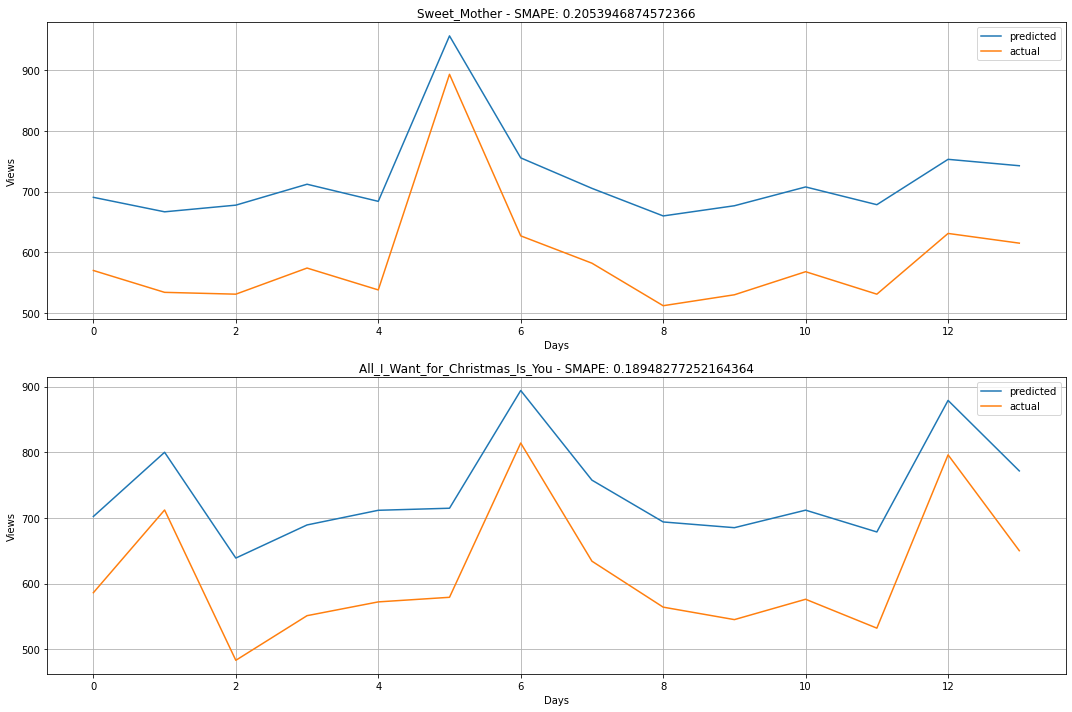

In [15]:
import matplotlib.pyplot as plt

song1 = 39
song2 = 3
loss1 = smape(predictions[song1].cpu().detach().numpy(),actuals[song1].cpu().detach().numpy())
loss2 = smape(predictions[song2].cpu().detach().numpy(),actuals[song2].cpu().detach().numpy())
fig, axs = plt.subplots(nrows=2, ncols=1,figsize=(15,10),tight_layout=True)
fig.tight_layout()
axs[0].plot(predictions[song1],label="predicted")
axs[0].plot(actuals[song1],label="actual")
axs[0].grid(True)
axs[0].legend()
axs[0].set_xlabel("Days")
axs[0].set_ylabel("Views")
axs[0].title.set_text(data["article"].unique()[song1] +f" - SMAPE: {loss1}")

axs[1].plot(predictions[song2],label="predicted")
axs[1].plot(actuals[song2],label="actual")
axs[1].grid(True)
axs[1].legend()
axs[1].set_xlabel("Days")
axs[1].set_ylabel("Views")
axs[1].title.set_text(data["article"].unique()[song2] +f" - SMAPE: {loss2}")


plt.show()


In [5]:
import plotly.express as px
import pandas as pd

df = pd.DataFrame({"Time":[668,73],
                   "Model":["LSTM","LSTM"],
                   "Training Type":["Training","Optimizing"]
                   })
fig = px.bar(df,y="Time",x="Model",color="Training Type",text="Time",color_discrete_sequence=px.colors.qualitative.T10)
fig.update_yaxes(title="Time in Minutes")
fig.update_layout(legend=dict(
    yanchor="bottom",
    y=0,
    xanchor="right",
    x=1.25,
    bgcolor="LightSteelBlue",
),title={
    "text":"Training Time",
    "x":0.45
})
min = 99999
max = 0

counter = 0
temp = 0
for t,_,_ in df.values:
    temp += t
    counter += 1
    if counter == 2:
        if temp> max:
            max = temp
        elif temp < min:
            min = temp
        temp = 0
        counter = 0

#fig.add_hline(min,line_width=3,line_dash="dash",line_color="#4ae004")
#fig.add_hline(max,line_width=3,line_dash="dash",line_color="red")
fig.update_traces(width=0.4)
fig.add_annotation(x=0, y=760,
            text="Total: 741 Minutes (12h:21m)",
            showarrow=False,font_size=15,font_family="Arial Black")
fig.show()
fig.write_image("training_time.png",format='png',engine='kaleido',scale=3)


<AxesSubplot:>

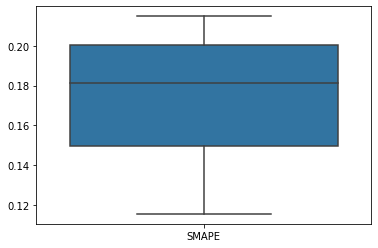

In [16]:
import seaborn as sns

losses = {"SMAPE":[]}
for i in range(51):
    losses["SMAPE"].append(smape(predictions[i].cpu().detach().numpy(),actuals[i].cpu().detach().numpy()))
sns.boxplot(data=pd.DataFrame(data=losses),orient="v")